In [221]:
!pip install tensorflow_datasets

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random

In [222]:
# Load the TensorBoard notebook extension.
# %reload_ext tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [223]:
DATASET_NAME = 'rock_paper_scissors'  # the name of dataset provided by tensorflow

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

In [224]:
print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(list(dataset_train_raw)), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(list(dataset_test_raw)), '\n')

Raw train dataset: <PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
Raw train dataset size: 2520 

Raw test dataset: <PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
Raw test dataset size: 372 



In [225]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('The amount of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('The amount of TEST examples:', NUM_TEST_EXAMPLES)
print('The amount of label classes:', NUM_CLASSES)

The amount of TRAIN examples: 2520
The amount of TEST examples: 372
The amount of label classes: 3


In [226]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

INPUT_IMG_SIZE_REDUCED = INPUT_IMG_SIZE_ORIGINAL // 2
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Here we may switch between bigger or smaller image sized that we will train our model on.
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 150
Input image shape (reduced): (150, 150, 3)


Input image size: 150
Input image shape: (150, 150, 3)


In [227]:
# Function to convert label ID to labels string.
get_label_name = dataset_info.features['label'].int2str

In [228]:
print(get_label_name(0));
print(get_label_name(1));
print(get_label_name(2));

rock
paper
scissors


In [229]:
def preview_ds(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

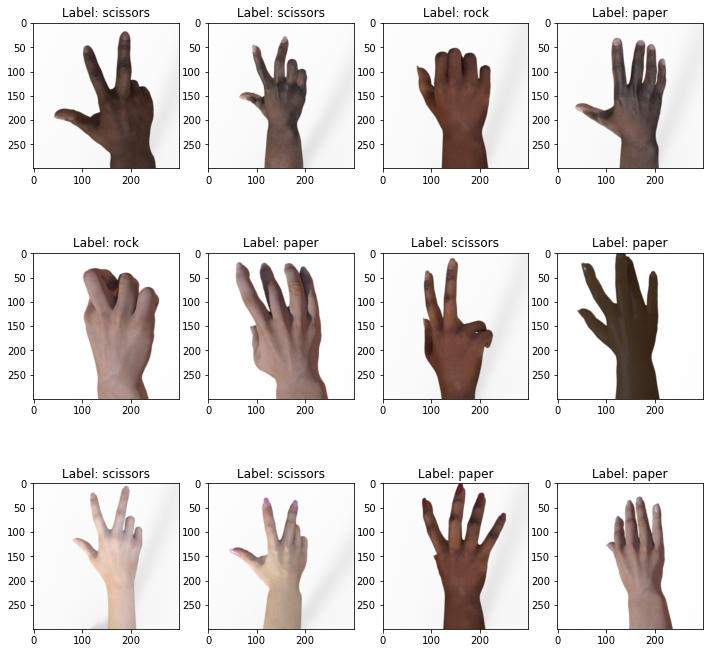

In [230]:
# Explore raw training dataset images.
preview_ds(dataset_train_raw)

In [231]:
# Explore what values are used to represent the image. 
(first_image, first_lable) = list(dataset_train_raw.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (300, 300, 3) 

[[[254 254 254]
  [253 253 253]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [250 250 250]]

 [[254 254 254]
  [254 254 254]
  [253 253 253]
  ...
  [250 250 250]
  [251 251 251]
  [249 249 249]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [252 252 252]]

 ...

 [[252 252 252]
  [251 251 251]
  [252 252 252]
  ...
  [247 247 247]
  [249 249 249]
  [248 248 248]]

 [[253 253 253]
  [253 253 253]
  [251 251 251]
  ...
  [248 248 248]
  [248 248 248]
  [248 248 248]]

 [[252 252 252]
  [253 253 253]
  [252 252 252]
  ...
  [248 248 248]
  [247 247 247]
  [250 250 250]]]


In [232]:
def formex(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [233]:
dataset_train = dataset_train_raw.map(formex)
dataset_test = dataset_test_raw.map(formex)

In [234]:
# Explore what values are used to represent the image. 
(first_image, first_lable) = list(dataset_train.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (150, 150, 3) 

[[[0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.9852941  0.9852941  0.9852941 ]
  [0.9843137  0.9843137  0.9843137 ]
  [0.98039216 0.98039216 0.98039216]]

 [[0.99607843 0.99607843 0.99607843]
  [0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.98333335 0.98333335 0.98333335]
  [0.9813726  0.9813726  0.9813726 ]
  [0.98333335 0.98333335 0.98333335]]

 [[0.99607843 0.99607843 0.99607843]
  [0.9941176  0.9941176  0.9941176 ]
  [0.9941176  0.9941176  0.9941176 ]
  ...
  [0.9852941  0.9852941  0.9852941 ]
  [0.9852941  0.9852941  0.9852941 ]
  [0.9813726  0.9813726  0.9813726 ]]

 ...

 [[0.9862745  0.9862745  0.9862745 ]
  [0.98725486 0.98725486 0.98725486]
  [0.9882353  0.9882353  0.9882353 ]
  ...
  [0.9705882  0.9705882  0.9705882 ]
  [0.97352946 0.97352946 0.97352946]
  [0.9754902  0.9754902  0.9754902 ]]

 [[0.9882353  0.9882353  0.9882353

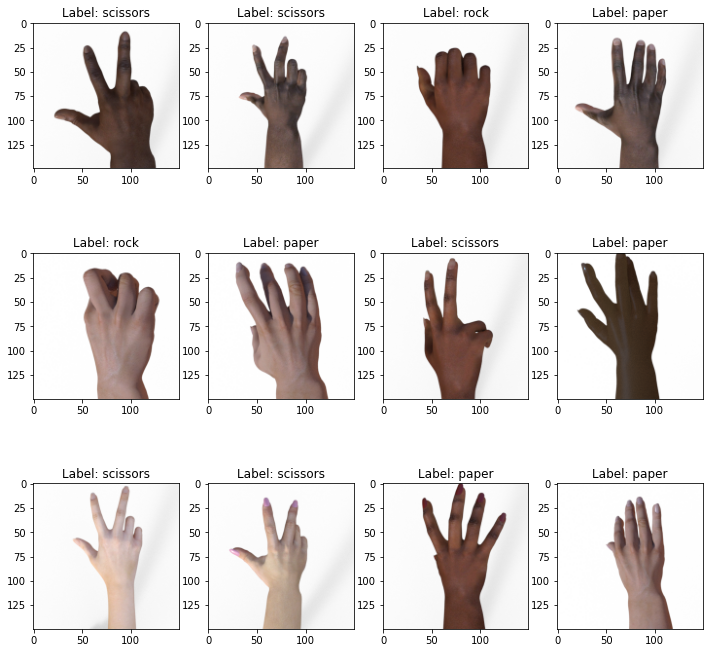

In [235]:
# Explore preprocessed training dataset images.
preview_ds(dataset_train)

In [236]:
def aug_fl(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

In [237]:
def aug_col(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

In [238]:
def aug_rot(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

In [239]:
def aug_inv(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [240]:
def aug_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]
        

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

In [241]:
def aug_dat(image, label):
    image = aug_fl(image)
    image = aug_col(image)
    image = aug_rot(image)
    image = aug_zoom(image)
    image = aug_inv(image)
    return image, label

In [242]:
dataset_train_augmented = dataset_train.map(aug_dat)

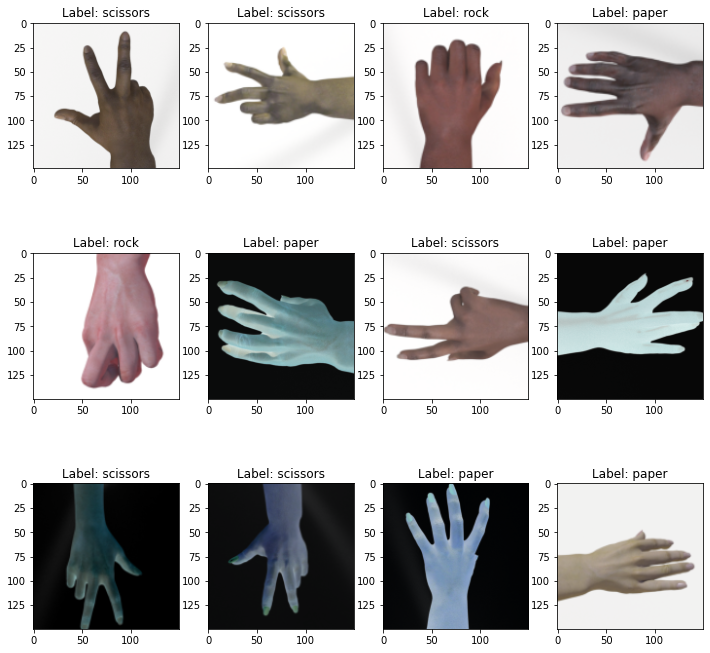

In [243]:
# Explore augmented training dataset.
preview_ds(dataset_train_augmented)

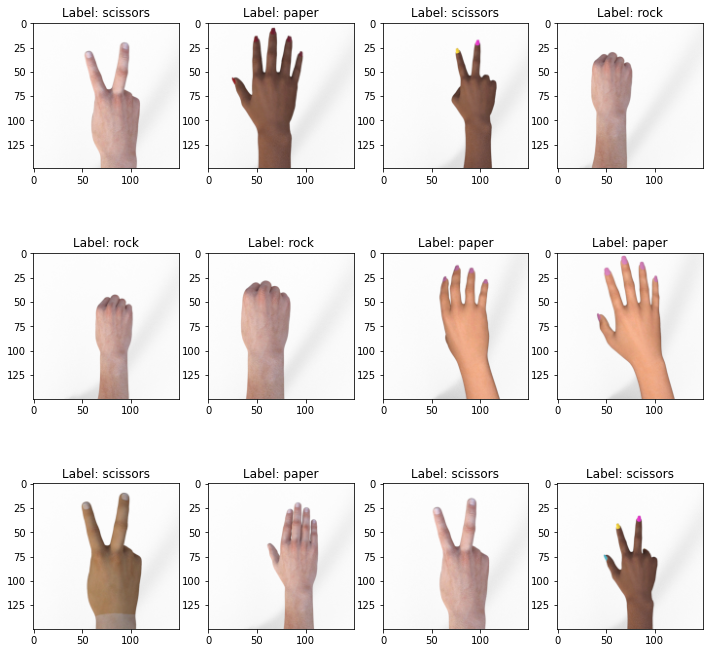

In [244]:
# Explore test dataset.
preview_ds(dataset_test)

In [245]:
BATCH_SIZE = 32

dataset_train_augmented_shuffled = dataset_train_augmented.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_augmented_shuffled = dataset_train_augmented.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

In [246]:
print(dataset_train_augmented_shuffled)
print(dataset_test_shuffled)

<PrefetchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int64)>


Label batch shape: (32,) 

Image batch shape: (32, 150, 150, 3) 

Label batch: [2 2 0 1 0 1 2 1 2 2 1 1 2 1 1 1 1 1 1 1 1 0 0 0 0 1 1 2 2 2 0 0] 

First batch image: [[[0.992855   0.98960435 0.9901288 ]
  [0.98851395 0.98526335 0.9857878 ]
  [0.99025047 0.9869998  0.9875243 ]
  ...
  [0.97722745 0.9739768  0.97450125]
  [0.9746227  0.9713721  0.9718966 ]
  [0.97722745 0.9739768  0.97450125]]

 [[0.99025047 0.9869998  0.9875243 ]
  [0.98938215 0.98613155 0.98665595]
  [0.98851395 0.98526335 0.9857878 ]
  ...
  [0.9720182  0.9687675  0.96929204]
  [0.975491   0.9722403  0.97276485]
  [0.9763592  0.97310853 0.973633  ]]

 [[0.98851395 0.98526335 0.9857878 ]
  [0.98938215 0.98613155 0.98665595]
  [0.99025047 0.9869998  0.9875243 ]
  ...
  [0.9746227  0.9713721  0.9718966 ]
  [0.97722745 0.9739768  0.97450125]
  [0.9789638  0.97571313 0.97623765]]

 ...

 [[0.9971961  0.9939454  0.9944699 ]
  [0.99545956 0.99220896 0.99273336]
  [0.99545956 0.99220896 0.99273336]
  ...
  [0.98764575 0.98439

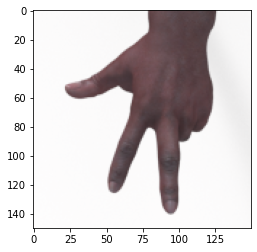

In [247]:
# Debugging the batches using conversion to Numpy arrays.
batches = tfds.as_numpy(dataset_train_augmented_shuffled)
for batch in batches:
    image_batch, label_batch = batch
    print('Label batch shape:', label_batch.shape, '\n')
    print('Image batch shape:', image_batch.shape, '\n')
    print('Label batch:', label_batch, '\n')
    
    for batch_item_index in range(len(image_batch)):
        print('First batch image:', image_batch[batch_item_index], '\n')
        plt.imshow(image_batch[batch_item_index])
        plt.show()
        # Break to shorten the output.
        break
    # Break to shorten the output.
    break

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
  input_shape=INPUT_IMG_SHAPE,
  include_top=False,
  weights='imagenet',
  pooling='avg'
)

In [249]:
# Freezing the base model since we don't want to re-train it.
# We're only interesting in its feature extraction.
base_model.trainable = False

In [250]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         input_13[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, None, None, 3 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [251]:
model = tf.keras.models.Sequential()

model.add(base_model)

# model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax,
    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
))

In [252]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [253]:
# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(
    optimizer=rmsprop_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [254]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE if NUM_TEST_EXAMPLES // BATCH_SIZE else 1

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 78
validation_steps: 11


In [255]:
# Preparing callbacks.
os.makedirs('logs/fit', exist_ok=True)
tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

os.makedirs('tmp/checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_accuracy'
    # monitor='val_loss'
)

In [256]:
initial_epochs = 20

In [257]:
training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
#         model_checkpoint_callback,
#         early_stopping_callback,
        tensorboard_callback
    ],
    verbose=1
)

Epoch 1/20
78/78 [==============================] - 58s 666ms/step - loss: 1.4267 - accuracy: 0.5672 - val_loss: 0.6675 - val_accuracy: 0.7415
Epoch 2/20
78/78 [==============================] - 45s 580ms/step - loss: 0.3676 - accuracy: 0.8742 - val_loss: 0.6214 - val_accuracy: 0.7926
Epoch 3/20
78/78 [==============================] - 46s 587ms/step - loss: 0.3073 - accuracy: 0.9132 - val_loss: 0.3839 - val_accuracy: 0.9176
Epoch 4/20
78/78 [==============================] - 45s 576ms/step - loss: 0.2310 - accuracy: 0.9384 - val_loss: 0.4576 - val_accuracy: 0.8807
Epoch 5/20
78/78 [==============================] - 47s 611ms/step - loss: 0.1813 - accuracy: 0.9512 - val_loss: 0.3487 - val_accuracy: 0.9148
Epoch 6/20
78/78 [==============================] - 48s 614ms/step - loss: 0.1814 - accuracy: 0.9582 - val_loss: 0.4311 - val_accuracy: 0.8636
Epoch 7/20
78/78 [==============================] - 45s 574ms/step - loss: 0.1897 - accuracy: 0.9511 - val_loss: 0.3246 - val_accuracy: 0.9261

In [258]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

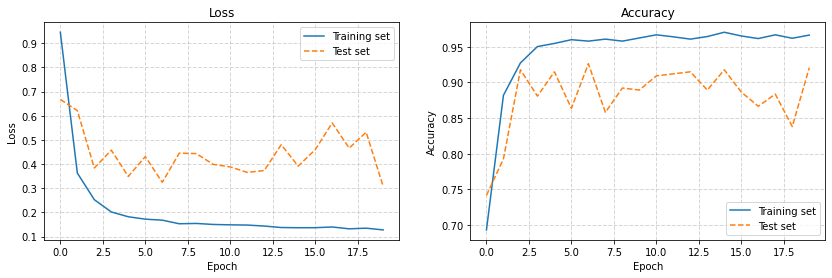

In [259]:
render_training_history(training_history)

In [260]:
# Un-freeze the top layers of the model
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [261]:
# Fine tune from this layer onwards.
fine_tune_at = 149

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# Compile the model using a much-lower training rate.
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(
    optimizer = rmsprop_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 723,843
Non-trainable params: 1,537,984
_________________________________________________________________


In [262]:
# The number of additional epochs during which we're going to fine tune the model.
fine_tuning_epochs = 10

In [ ]:
training_history_fine = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=initial_epochs + fine_tuning_epochs,
    initial_epoch=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[tensorboard_callback],
    verbose=1
)

Epoch 21/30
78/78 [==============================] - 58s 677ms/step - loss: 0.1422 - accuracy: 0.9654 - val_loss: 0.5896 - val_accuracy: 0.8523
Epoch 22/30
78/78 [==============================] - 47s 605ms/step - loss: 0.0903 - accuracy: 0.9874 - val_loss: 0.7006 - val_accuracy: 0.8239
Epoch 23/30
78/78 [==============================] - 45s 580ms/step - loss: 0.0606 - accuracy: 0.9929 - val_loss: 0.6322 - val_accuracy: 0.8523
Epoch 24/30
78/78 [==============================] - 47s 602ms/step - loss: 0.0598 - accuracy: 0.9932 - val_loss: 0.5172 - val_accuracy: 0.8892
Epoch 25/30
78/78 [==============================] - 44s 565ms/step - loss: 0.0565 - accuracy: 0.9951 - val_loss: 0.5734 - val_accuracy: 0.8636
Epoch 26/30
17/78 [=====>........................] - ETA: 29s - loss: 0.0367 - accuracy: 1.0000

In [ ]:
loss = training_history.history['loss'] + training_history_fine.history['loss']
val_loss = training_history.history['val_loss'] + training_history_fine.history['val_loss']

accuracy = training_history.history['accuracy'] + training_history_fine.history['accuracy']
val_accuracy = training_history.history['val_accuracy'] + training_history_fine.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.plot(
[initial_epochs, initial_epochs], 
plt.ylim(),
label='Start Fine Tuning',
linestyle='--'
)
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='--')
plt.plot(
[initial_epochs, initial_epochs], 
plt.ylim(),
label='Start Fine Tuning',
linestyle='--'
)
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

In [ ]:
# %%capture
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)

In [ ]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

In [ ]:
# model_name = 'mobilenet_rps.h5'
# model.save(model_name, save_format='h5')

In [ ]:
# !pip install tensorflowjs
# import tensorflowjs as tfjs


# tfjs.converters.save_keras_model(model, 'models')

In [ ]:
# tfjs.converters.save_keras_model(model, 'models')